#### Time series analysis

This notebook fits time-series analysis models to NYC attendance data to get predict future absence rates.

In [224]:
import glob # TODO: Check whether this is still used, if not, delete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pmdarima as pm
import os # TODO: Check whether this is still used, if not, delete
import seaborn as sns
import skforecast


from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.recursive import ForecasterRecursive
# TODO: Check which of the following get used once notebook is finalized,
# gid rid of rest
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster, TimeSeriesFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA

#### Reading in, examining, and preparing the attendance data

I took a random sample of 15 schools, but the original open source data from NYC had thousands of schools! We will be working with just one school here, but feel free to try out these models later on your own with other schools.

In [225]:
# Saving url for Git repository
git_url = 'https://github.com/tarachiatovich/zero_to_ai_sdp_2025/'
# Reading in data from Git
# Datasource (open, publicly available):
# https://opendata.cityofnewyork.us/

# TODO: Will need to update once branch is merged
git_nyc_path = git_url +\
    'blob/improve_tabular_notebooks/clean_data/attendance/full_attendance_data.csv?raw=true'

In [226]:
attendance_data = pd.read_csv(git_nyc_path)

In [227]:
# Look at the columns
attendance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26766 entries, 0 to 26765
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   School      26766 non-null  object 
 1   Date        26766 non-null  object 
 2   SchoolYear  26766 non-null  int64  
 3   Enrolled    26762 non-null  float64
 4   Absent      26762 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [228]:
# Skipping to save time, but you can uncomment
# to get a frequency table for School values
# attendance_data['School'].value_counts()

School
07X223    2086
03M149    2083
01M015    2083
27Q060    2083
10X080    2083
09X229    2083
06M322    2081
02M630    1947
12X479    1947
02M418    1942
02M420    1942
02M267    1902
05M514    1721
04M310     618
18K500     165
Name: count, dtype: int64

In [229]:
# We need the Date column to be an official
# datetime object
attendance_data['Date'] = pd.to_datetime(
    attendance_data['Date'],
    dayfirst=False, format='mixed'
)

In [230]:
# We're going to work with just one school for now,
# though you can do the same analysis choosing another
# school later on
school_id_to_use = '01M015'

In [231]:
# Creating a dataframe limited to one school
data_1_school = attendance_data.loc[attendance_data['School'] == school_id_to_use].sort_values('Date')

In [232]:
# Skipping for time, but you can uncomment
# This checks that each date appears only
# once in the data
# data_1_school.Date.value_counts()

Date
2021-06-25    1
2009-09-09    1
2009-09-10    1
2021-06-01    1
2021-05-28    1
             ..
2009-09-18    1
2009-09-17    1
2009-09-16    1
2009-09-15    1
2009-09-14    1
Name: count, Length: 2083, dtype: int64

<Axes: xlabel='Date', ylabel='Count'>

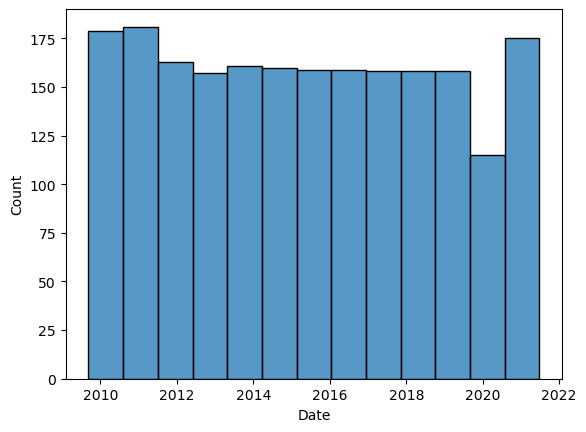

In [233]:
# Look at histogram giving dates for first school
# These bars look nice and even, except for circa
# 2020, which is no surprise given the pandemic
sns.histplot(data=data_1_school, x='Date')

In [235]:
# Create an absence rate that adjusts for enrollment
data_1_school['AbsenceRate'] = data_1_school['Absent']/data_1_school['Enrolled']

In [236]:
# Let's get descriptives on AbsenceRate
data_1_school[['AbsenceRate', 'Absent']].describe()

,AbsenceRate,Absent
count,2083.000000,2083.000000
mean,0.081130,15.245319
std,0.054027,10.506703
min,0.000000,0.000000
25%,0.047120,9.000000
50%,0.068421,13.000000
75%,0.097826,18.500000
max,0.618090,123.000000


In [237]:
# Skipping for time -- you can uncomment if desired
# Look at first few rows of data with AbsenceRate
# data_1_school.head()

,School,Date,SchoolYear,Enrolled,Absent,AbsenceRate
0,01M015,2009-09-09,20092010,210.0,36.0,0.171429
1,01M015,2009-09-10,20092010,215.0,22.0,0.102326
2,01M015,2009-09-11,20092010,213.0,28.0,0.131455
3,01M015,2009-09-14,20092010,214.0,15.0,0.070093
4,01M015,2009-09-15,20092010,214.0,20.0,0.093458


#### Creating training and testing data

We will fit our model on training data, adjust it based on how it performs on validition data, and then do a final check of how it does on "hold out" or "out of bag" testing data.

In [262]:
# Let's get the data ready for analyses by splitting
# Date into training, validiation, and testing sets
tscv = TimeSeriesSplit(n_splits=2, test_size=180)
data_1_school_for_ts = data_1_school.copy()

In [265]:
# Getting together the "split" data
# TimeSeriesSplit splits the data twice, into two folds.
# We can use data from the first fold to get our model up and running
# and then once we are happy with our model for that dataframe, do a final check
# of how it runs on the dataframe from the second fold.
train_test_indices = {}
for i, (train_index, test_index) in enumerate(tscv.split(data_1_school_for_ts['Date'])):
    train_test_indices[f"train_fold_{i}"] = train_index
    train_test_indices[f"test_fold_{i}"] = test_index

Fold 0:
  Train: index=[   0    1    2 ... 1720 1721 1722]
  Test:  index=[1723 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736
 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750
 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764
 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778
 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792
 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806
 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820
 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834
 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848
 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862
 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876
 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890
 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902]
Fold 1:
  Tr

In [266]:
# This part is very "Python-y" and may be confusing for people who are new to Python
# It just uses indices to get the right parts of the data for training, validition,
# and "hold out"/"out of bag" testing

# Use the indices [0] and [-1] to get the first part and last Date for the training
# data
train_start = data_1_school_for_ts.iloc[train_test_indices['train_fold_0'][0]]['Date']
train_end = data_1_school_for_ts.iloc[train_test_indices['train_fold_0'][-1]]['Date']

# Do the same as above, but this time for our validation data
val_start = data_1_school_for_ts.iloc[train_test_indices['test_fold_0'][0]]['Date']
val_end = data_1_school_for_ts.iloc[train_test_indices[test_fold_0"][-1]]['Date']

# Let's also get our "hold out"/"out of bag" data now so we'll be ready to see how
# the model performs with unseen data
hold_out_test_start = data_1_school_for_ts.iloc[train_test_indices['test_fold_1'][0]]['Date']
hold_out_test_end = data_1_school_for_ts.iloc[train_test_indices['test_fold_1'][-1]]['Date']

In [247]:
# Let's check on the start and end dates for taining and
# validition data
print(train_start)
print(train_end)
print(val_start)
print(val_end)

2009-09-09 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2020-03-06 00:00:00


In [267]:
# And we'll also look at the start and end
# dates for our hold out data
print(hold_out_test_start)
print(hold_out_test_end)

2020-03-09 00:00:00
2021-06-25 00:00:00


In [248]:
data_1_school_for_ts.set_index('Date', inplace = True)

In [249]:
data_1_school_for_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2083 entries, 2009-09-09 to 2021-06-25
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   School       2083 non-null   object 
 1   SchoolYear   2083 non-null   int64  
 2   Enrolled     2083 non-null   float64
 3   Absent       2083 non-null   float64
 4   AbsenceRate  2083 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 97.6+ KB


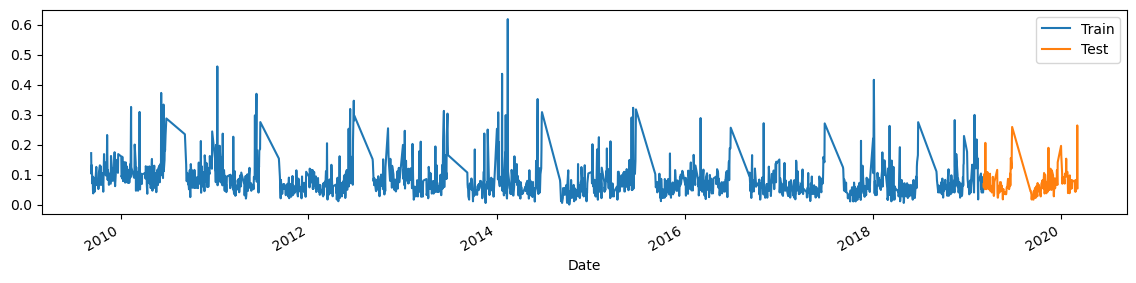

In [250]:
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end].plot(ax=ax, label = "Train")
data_1_school_for_ts['AbsenceRate'].loc[val_start: val_end].plot(ax=ax, label = "Test")
ax.legend()

In [270]:
# Source consulted when writing the code:
# https://medium.com/@mouse3mic3/a-practical-guide-on-scikit-learn-for-time-series-forecasting-bbd15b611a5d

# Supressing a warning message (not important)
# warnings.simplefilter('ignore', category=IndexWarning)

# Set the values for the index for the predictions, based
# on start and end dates for test
dates_for_preds = data_1_school_for_ts.loc[val_start: val_end].index.values
# Define the forecaster
forecaster_tree=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=DecisionTreeRegressor(random_state=123),
    lags=20
)
# Define the forecaster
forecaster_lgbmr=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=LGBMRegressor(random_state=123, verbose=-1),
    lags=20
)

# Store the model algorithms in a list for looping
model_algs = [forecaster_tree, forecaster_lgbmr]
# Store a name for each model algorithm, also for looping
model_names = ['tree', 'lgbmr']
# Create an empty map for storing the data, the root mean square error
reg_model_preds = {}
reg_model_rmses = {}
# Fit the models using train data
for model_alg, model_name in zip(model_algs, model_names):
    model_alg.fit(y = data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end])

    # Predict the test period
    predicted_test = model_alg.predict(
        steps = len(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end])
    )
    predicted_test = pd.DataFrame(predicted_test)
    predicted_test['Date'] = dates_for_preds
    predicted_test.set_index('Date', inplace = True)

    # Get RMSE
    rmse_test = np.sqrt(mean_squared_error(
        data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end],
        predicted_test)
    )
    print(f'RMSE for {model_name}')
    print('RMSE Test:', rmse_test)

    # Store results in reg_model_results, with model specified
    reg_model_preds[model_name] = predicted_test
    reg_model_rmses[model_name] = rmse_test

KeyError: Timestamp('2019-03-07 00:00:00')

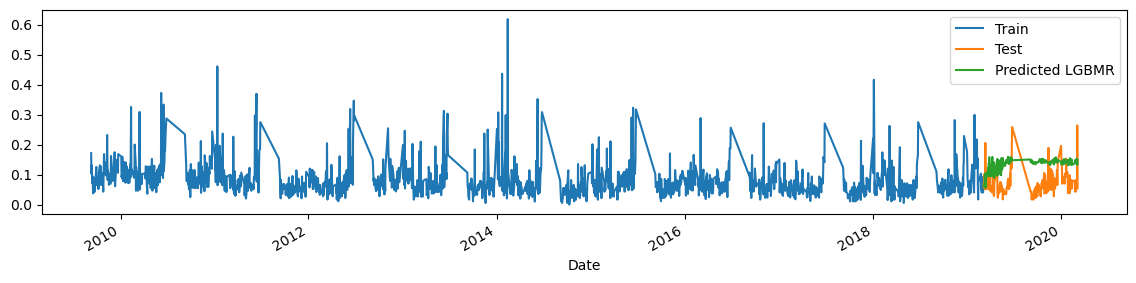

In [253]:
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end].plot(ax=ax, label = "Train")
data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end].plot(ax=ax, label = "Test")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label = "Predicted LGBMR")
ax.legend()

In [254]:
# TODO: Fix warnings!
# TODO: Incorporate into loop?
arima = pm.AutoARIMA(seasonal = True)
arima.fit(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end])

# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end]))
arima_test = pd.DataFrame(arima_test, columns=['pred'])
arima_test = arima_test.set_index(dates_for_preds)

arima_rmse_train = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end], arima_train))
arima_rmse_test = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end], arima_test))
print('ARIMA RMSE Train:', arima_rmse_train,'\nARIMA RMSE Test:', arima_rmse_test)

C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'e

ARIMA RMSE Train: 0.05061004877462674 
ARIMA RMSE Test: 0.04074518357742449


C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [89]:
# Source on parameters for ARIMA
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

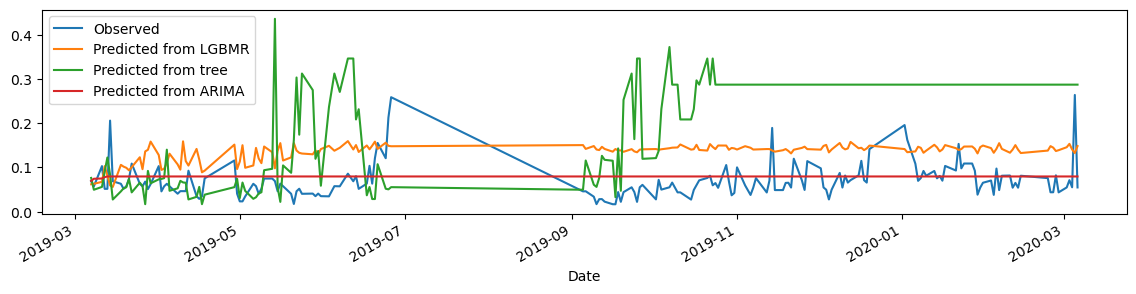

In [256]:
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
# reg_model_preds['tree']['pred'].plot(ax=ax, label="Predicted from tree")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

In [257]:
# Hyperparameter tuning for most promising model: light gradient boosting machine regressor
# Code inspired by this source:
# https://skforecast.org/0.15.0/user_guides/hyperparameter-tuning-and-lags-selection.html
# Also see this source: https://cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 20]
}

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end]),
         refit              = False
     )

results = grid_search_forecaster(
              forecaster    = forecaster_lgbmr,
              y             = data_1_school_for_ts['AbsenceRate'].loc[train_start:val_end].reset_index(drop=True),
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error', # What we are trying to minimize
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
# Showing the parameters, mean_squared_error for the best model
results[0]

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.0017689823317217275


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 50}",0.001769,5,50
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 5, 'n_estimators': 50}",0.001827,5,50
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 50}",0.001837,15,50
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 5, 'n_estimators': 100}",0.001911,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 100}",0.001922,15,100
5,"[1, 2, 3, 20]",lags_3,"{'max_depth': 5, 'n_estimators': 50}",0.001933,5,50
6,"[1, 2, 3, 20]",lags_3,"{'max_depth': 5, 'n_estimators': 100}",0.001936,5,100
7,"[1, 2, 3]",lags_1,"{'max_depth': 15, 'n_estimators': 50}",0.001948,15,50
8,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 100}",0.001996,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 10, 'n_estimators': 50}",0.002014,10,50


Important note: We do not have a demonstration of hyperparamter tuning for auto-ARIMA because the package we used for auto-ARIMA in Python chooses the single best model according to what we specified when fitting it. Read more here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [258]:
# Get predictions from tuned LGBMR forecaster
# We can do this because above we had return_best = True
# That means that grid_search_forecaster updated our forecaster_lgbmr model
# to have the tuned (best) hyperparameters
# So when we run `forecaster_lgbmr.predict` below, we are getting predictions
# using the tuned LGBMR model
predicted_val_tuned_lgbmr = forecaster_lgbmr.predict(steps = len(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end]))
predicted_val_tuned_lgbmr = pd.DataFrame(predicted_val_tuned_lgbmr)
predicted_val_tuned_lgbmr['Date'] = dates_for_preds
predicted_val_tuned_lgbmr.set_index('Date', inplace = True)

# Get RMSE from tuned LGBMR forecaster
rmse_tuned_lgbmr = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end], predicted_val_tuned_lgbmr['pred']))

# Print RMSE, original and tuned
print(f"Light GRM regressor best root mean square error:  {rmse_tuned_lgbmr}")
print(f"Light GRM regressor untuned (original) root mean square error:  {reg_model_rmses['lgbmr']}")

Light GRM regressor best root mean square error:  0.06384729598807931
Light GRM regressor untuned (original) root mean square error:  0.07893585132004702


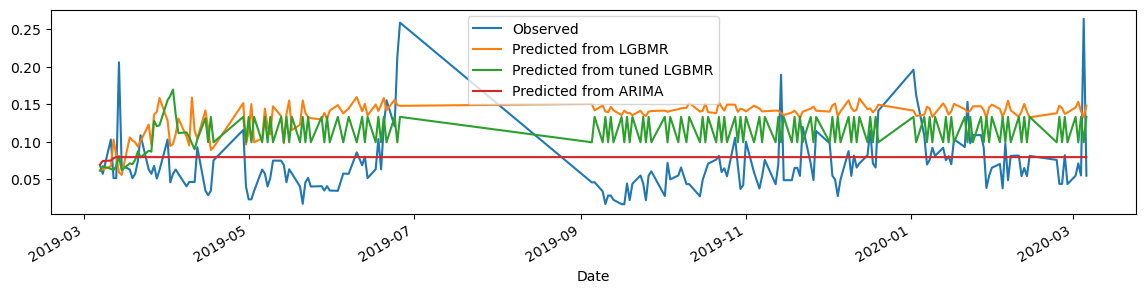

In [259]:
# Add data viz like the above but for "most likely" algorithms
# Point is (at least in part) to show that backfitting and hyperparameter tuning helped
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[val_start:val_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
predicted_val_tuned_lgbmr['pred'].plot(ax=ax, label="Predicted from tuned LGBMR")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

The green line above showing the predicted values from the tuned LGBMR model shows a clear improvement over the original (untuned, default) LGBMR model. However, its predictions are still too high much of the time. The predictions from our auto-ARIMA model don't follow the peaks and valleys nearly as well, but do you think that model is doing better overall? Look back at the root mean squared error from the auto-ARIMA model to answer.

In [260]:
# Commented out for time -- don't run this during the session,
# but you can use this to try out different things on your own

# Is there anything you'd like to do differently? What if you went through
# parameter tuning using a different metric?
# Run this cell and see in the help for grid_search_forecaster
# what options you have for metrics.
# help(grid_search_forecaster)

Help on function grid_search_forecaster in module skforecast.model_selection._search:

grid_search_forecaster(forecaster: 'object', y: 'pd.Series', cv: 'TimeSeriesFold | OneStepAheadFold', param_grid: 'dict', metric: 'str | Callable | list[str | Callable]', exog: 'pd.Series | pd.DataFrame | None' = None, lags_grid: 'list[int | list[int] | np.ndarray[int] | range[int]] | dict[str, list[int | list[int] | np.ndarray[int] | range[int]]] | None' = None, return_best: 'bool' = True, n_jobs: 'int | str' = 'auto', verbose: 'bool' = False, show_progress: 'bool' = True, output_file: 'str | None' = None) -> 'pd.DataFrame'
    Exhaustive search over specified parameter values for a Forecaster object.
    Validation is done using time series backtesting.

    Parameters
    ----------
    forecaster : ForecasterRecursive, ForecasterDirect
        Forecaster model.
    y : pandas Series
        Training time series.
    cv : TimeSeriesFold, OneStepAheadFold
        TimeSeriesFold or OneStepAheadFold 

#### The final step!

Once you have done all you plan to do to improve your predictions with your model, you can see how it runs on the "hold out"  or "out of bag" data, the data we've never looked at before. This gives us a better sense of how we expect the model to perform in real time with data it has never "seen" before.

This will be...interesting...because the out of bag data include the beginning of the pandemic!

In [268]:
# Getting final predictions and final metrics
# Since we are having grid_search_forecaster return
# the best model, the line below should give predictions
# from your best model from your most recent running
# of grid_search_predictor
predicted_hold_out_lgbmr = forecaster_lgbmr.predict(
    steps = len(data_1_school_for_ts['AbsenceRate'].loc[hold_out_test_start:hold_out_test_end])
)
predicted_hold_out_lgbmr = pd.DataFrame(predicted_hold_out_lgbmr)
predicted_hold_out_lgbmr['Date'] = dates_for_preds
predicted_hold_out_lgbmr.set_index('Date', inplace = True)

# Getting the RMSE, though maybe you want to gauge the
# model's performance from a different metric. Up to you!
rmse_hold_out_lgbmr = np.sqrt(
    mean_squared_error(
        data_1_school_for_ts['AbsenceRate'].loc[hold_out_test_start:hold_out_test_end],
        predicted_hold_out_lgbmr['pred']
    ))

In [ ]:
# How does the final model look with the hold out data?
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[hold_out_test_start:hold_out_test_end].plot(ax=ax, label = "Observed")
predicted_hold_out_lgbmr['pred'].plot(ax=ax, label="Hold out predicted from final LGBMR")
ax.legend()